In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *

In [12]:
N_EPOCHS =5000
#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 
print(x_min,x_max)

#encoder = CategoricalEncoder(mu0,sigma0,q0)
N=50
decoder = MoGDecoder(N,x_min,x_max)
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))

#Define optimizer and parameters to iterate on
params =  decoder.parameters()
optimizer = torch.optim.SGD(params,0.01,momentum=0.9)
loss = simplified_loss(x_data,decoder)
loss.backward()

0.0005553743685595691 12.95254898071289


   [ 1.5628e-03],
        [ 1.5466e-03],
        [-1.1322e-04],
        [ 1.1765e-03],
        [ 6.4242e-04],
        [ 1.6601e-03],
        [ 1.2830e-03],
        [ 1.0450e-03],
        [ 1.4005e-03],
        [ 1.3907e-03],
        [ 1.0945e-03],
        [ 4.4970e-04],
        [ 7.4369e-04],
        [ 6.0853e-04],
        [ 3.8671e-04],
        [ 2.8297e-04],
        [ 2.7558e-04],
        [ 3.2168e-04],
        [ 1.9930e-03]])
tensor([[-8.6278e-06],
        [-1.7330e-05],
        [ 9.6515e-05],
        [-5.0455e-05],
        [-1.7893e-05],
        [ 1.1926e-04],
        [-1.0225e-04],
        [-1.5998e-04],
        [-1.3134e-04],
        [ 6.8747e-04],
        [ 6.4982e-05],
        [-2.0046e-05],
        [ 2.2768e-03],
        [ 6.4388e-05],
        [ 2.0287e-04],
        [ 9.0993e-05],
        [ 1.3639e-04],
        [ 1.6667e-04],
        [ 3.7953e-03],
        [-6.3965e-05],
        [-3.2760e-04],
        [ 2.0137e-03],
        [-3.3958e-04],
        [ 2.8234e-04],
        [ 9.489

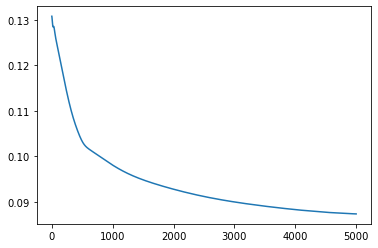

In [13]:
#Ideal loss
lossVec = []
DVec = []
mseVec = []
for epoch in range(N_EPOCHS):
    loss = simplified_loss(x_data,decoder)
    lossVec.append(loss.item())
    mse = MSE_cat(x_data,decoder)
    mseVec.append(mse.item())
    encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
    DVec.append(distortion_cat(x_data,encoder,decoder).item())
    optimizer.zero_grad()
    loss.backward()
    #print(decoder.log_sigmas.grad)
    optimizer.step()
plt.plot(mseVec)

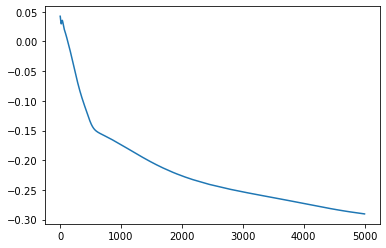

In [15]:
plt.plot(DVec)

In [6]:
params =  list(encoder.parameters())+list(decoder.parameters())
optimizer = torch.optim.SGD(params,0.01,momentum=0.9)
lossVec = []
mseVec = []
for epoch in range(N_EPOCHS):
    dis_loss = distortion_cat(x_data,encoder,decoder)
    rate_loss = rate_cat(x_data,encoder,decoder)
    loss = dis_loss + rate_loss
    #loss = simplified_loss(x_data,decoder)
    lossVec.append(loss.item())
    #print(torch.softmax(decoder.qs,dim=1))
    mse = MSE_cat(x_data,decoder,encoder)
    mseVec.append(mse.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

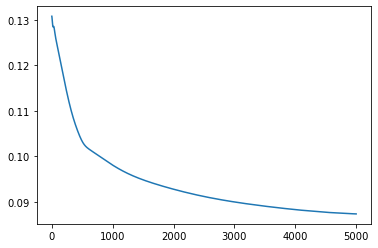

In [14]:
plt.plot(mseVec)

In [3]:
MSE_cat()

TypeError: MSE_cat() missing 2 required positional arguments: 'x' and 'decoder'

In [1]:
x_sorted[0:500]

NameError: name 'x_sorted' is not defined